In [1]:
#imports

import numpy as np
import shelve
from astropy.table import QTable
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
from astropy.table import QTable
import os
import math
import shutil
from IPython.core.debugger import Tracer
import subprocess
import re
%matplotlib inline


#initial conditions
stable_ICs = shelve.open('stable_ICs')
ecc_b = stable_ICs['ecc_b']
ecc_c = stable_ICs['ecc_c']
semi_b = stable_ICs['semi_b']
semi_c = stable_ICs['semi_c']
dInc_b = stable_ICs['dInc_b']
dInc_c = stable_ICs['dInc_c']
dLongA_b = stable_ICs['dLongA_b']
dLongA_c = stable_ICs['dLongA_c']
dArgP_b = stable_ICs['dArgP_b']
dArgP_c = stable_ICs['dArgP_c']
mean_an_b = stable_ICs['mean_an_b']
mean_an_c = stable_ICs['mean_an_c']
good_hill = stable_ICs['good_hill']
bad_hill = stable_ICs['bad_hill']
dPrecA_b = stable_ICs['dPrecA_b']
dMass_star = stable_ICs['dMass_star']
dRadius_star = stable_ICs['dRadius_star']
dMass_b = stable_ICs['dMass_b']
dMass_c = stable_ICs['dMass_c']
dRadius_b = stable_ICs['dRadius_b']
dRadius_c = stable_ICs['dRadius_c']
dTidalQ_b = stable_ICs['dTidalQ_b']
dTidalQ_c = stable_ICs['dTidalQ_c']
dTidalQ_star = stable_ICs['dTidalQ_star']
dStopTime = stable_ICs['dStopTime']
stable_ICs.close()

In [2]:
#pulls finished data from local eqtide only runs

t = 25000 # number of sims



#finished data
data_merged_runs = np.array([])
data_age = np.array([])
data_semi = np.array([])
data_ecc = np.array([])
data_m_star = dMass_star
data_m_b = dMass_b
data_per = np.array([])


folders = np.array([]) # corresponding folders



n = 0
while n <= t-1:     # builds the final vars from output files
    name_idx = '%05i'%n
    folder_name = name_idx
    wd = './runs/'+folder_name
    fwd = open(wd+'/system.b.forward','r') #forward file
    fwd_content = fwd.read()
    fwd_content = fwd_content.split('\n') #split by line
    last_line = fwd_content[-2] #gets the last line of output, (last data before merge/completion)
    last_line = last_line.split(' ')
    max_age = last_line[0]
    max_age = float(max_age)
    str_max_age = str(max_age)
    str_max_age = str_max_age[0]
    sdigit_max_age = int(str_max_age)
    
    if max_age<=3e09: #throws away so able to generate age b/w 2 and 8 (excludes 2 and 2)
        data_merged_runs = np.append(data_merged_runs,int(folder_name))
    else:
        if max_age < 8e09: #generates age to max age
            age_rand = np.random.randint(2,sdigit_max_age)
            data_age = np.append(data_age,age_rand)
        
        elif max_age >= 8e09: #generates age 2 to 8 gyrs
            age_rand = np.random.randint(2,9)
            data_age = np.append(data_age,age_rand)

            
            
        line = fwd_content[age_rand]
        age = int(line[0])
        data = line.split(" ")
        ecc = float(data[2])
        semi = float(data[1])
        data_ecc = np.append(data_ecc,ecc)
        data_semi = np.append(data_semi,semi)
        #Tracer()()

    
    n += 1
data_m_star = np.delete(data_m_star,data_merged_runs)
data_m_b = np.delete(data_m_b,data_merged_runs)
data_m_b = abs(data_m_b)

data_m_star = data_m_star * u.solMass #solar mass
data_m_b = data_m_b * u.earthMass


a = data_semi * u.AU
per = np.sqrt(((4 * np.pi**2)/(const.G*(data_m_b + data_m_star)))*a**3)
per = per.decompose()
per = per.to(u.day)
per = per.value
data_per = per
# now to combine it all





In [3]:
data_semi = np.transpose(data_semi)
data_ecc = np.transpose(data_ecc)
data_age = np.transpose(data_age)
data_per = np.transpose(data_per)
data = np.vstack((data_age,data_semi,data_ecc,data_per))
data = np.transpose(data)
data.shape

(23248, 4)

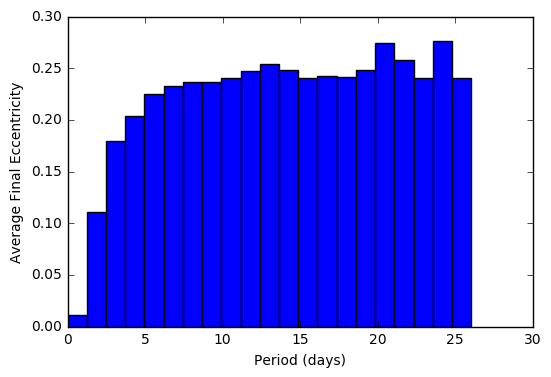

In [4]:
n = 20 #number of bins
binwidth = (max(data_per)-min(data_per))/n

#generate x axis'
x = np.arange(0,max(data_per),binwidth)
avg_ecc = np.array([])
#generate y axis, avg ecc per bin;



for l in x:
    
    lb = l
    ub = lb+binwidth
    ecc_bin = np.array([])
    
    for idx,per in enumerate(data_per):
        if per >= lb and per <= ub:
            ecc_bin = np.append(ecc_bin,data_ecc[idx])
            
    avg_ecc_bin = np.mean(ecc_bin)
    avg_ecc = np.append(avg_ecc,avg_ecc_bin)

    
x.shape,avg_ecc.shape,avg_ecc

fig,ax = plt.subplots(1,1)
ax.bar(x,avg_ecc,width=binwidth)
ax.set_xlabel('Period (days)')
ax.set_ylabel('Average Final Eccentricity')
        
    

In [5]:
# to find the run with the highest period:
print (np.argmax(data_per),data_per[np.argmax(data_per)])

12842 25.060531163


In [2]:
# reads in table for completed hyak runs;
# completed.csv is from hyak, scp to local machine for updated list;
c = QTable.read('completed.csv',format='ascii.csv')

# define some masks for analysis 

max_mask = np.where(c['Runtime']==max(c['Runtime']))
avg_runtime = c['Runtime'].mean()
g_avg_mask = np.where(c['Runtime']>avg_runtime) # gives runtimes greater than average


g_day_mask = np.where(c['Runtime']>=86400) # 86400 is 1 day in seconds
print(c)
c[max_mask]

 Sim #      Semi_b_0       Semi_c_0    ...   LongA_c_0       Mut Incl    Runtime
------- --------------- -------------- ... ------------- --------------- -------
    0.0 0.0760256758106 0.456496984372 ... 289.627701887  0.219738085531   402.0
    1.0 0.0275818745731 0.400032698501 ... 214.494881545  0.226545183975   373.0
    2.0 0.0497165502734 0.156275025853 ... 190.741890153  0.040891802183  5404.0
    3.0  0.035336142441  0.27259331901 ... 186.030522952    0.2525936426 22068.0
    4.0 0.0920345240145 0.354064843507 ... 264.947428804  0.296830448795  1409.0
    5.0 0.0285777220004 0.482277230015 ... 207.591148766  0.124472016409   478.0
    6.0 0.0934585654024 0.322711725359 ... 175.283867417 0.0964207840754 63192.0
    7.0 0.0131435415743 0.555634706022 ... 204.807532053  0.069248454224     5.0
    8.0  0.117606892348 0.473743106142 ... 79.3231060181 0.0747712911502  4533.0
    9.0  0.146703065903 0.531626195845 ... 266.860443601 0.0233826569933   307.0
    ...             ...     

Sim #,Semi_b_0,Semi_c_0,Ecc_b_0,Ecc_c_0,Inc_b_0,Inc_c_0,LongA_b_0,LongA_c_0,Mut Incl,Runtime
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
7307.0,0.0602834426854,0.180764204699,0.310173841938,0.127984372696,0.0,4.84316097782,173.606562099,210.688984601,0.0845291052671,319222.0


Sim #,Semi_b_0,Semi_c_0,Ecc_b_0,Ecc_c_0,Inc_b_0,Inc_c_0,LongA_b_0,LongA_c_0,Mut Incl,Runtime
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3606.0,0.0685555503674,0.157184703842,0.260058021118,0.217804031176,2.29029748638,293.307048178,96.720005174,293.307048178,1.12573114474,172695.0
11435.0,0.141367259784,0.249140353074,0.513499456189,0.0297409931488,4.00001776711,343.648935234,281.246459097,343.648935234,0.323527657446,172423.0
21816.0,0.0818259558132,0.231221807645,0.514911791103,0.280466183399,0.922026620585,259.779415771,215.874421848,259.779415771,1.76076210557,172265.0
8325.0,0.0899780351468,0.221368460311,0.0114501785831,0.170421882592,3.41556851962,200.989091472,225.96612809,200.989091472,2.82833422695,171026.0
3122.0,0.10705348461,0.261658153164,0.152483998382,0.291324056275,2.15932919992,101.99124684,208.168175554,101.99124684,1.79044121608,170670.0
13113.0,0.0812372181623,0.167796705215,0.223752309511,0.119142518183,2.99477642141,258.070183489,201.622011234,258.070183489,1.80768846198,170374.0
17078.0,0.135584827915,0.243664581585,0.0761965770013,0.17051807497,0.431954862714,189.555461811,176.257464485,189.555461811,2.98214593074,170259.0
24723.0,0.146992731145,0.253994966312,0.329636667388,0.0335392440285,3.21317392012,297.681297027,325.685248293,297.681297027,1.13735265037,169960.0
8186.0,0.125167542881,0.265261534152,0.0672165602776,0.0228146870153,3.30112999485,253.422037732,208.220865703,253.422037732,1.90047005041,169779.0


/home/dm1681/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/dm1681/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


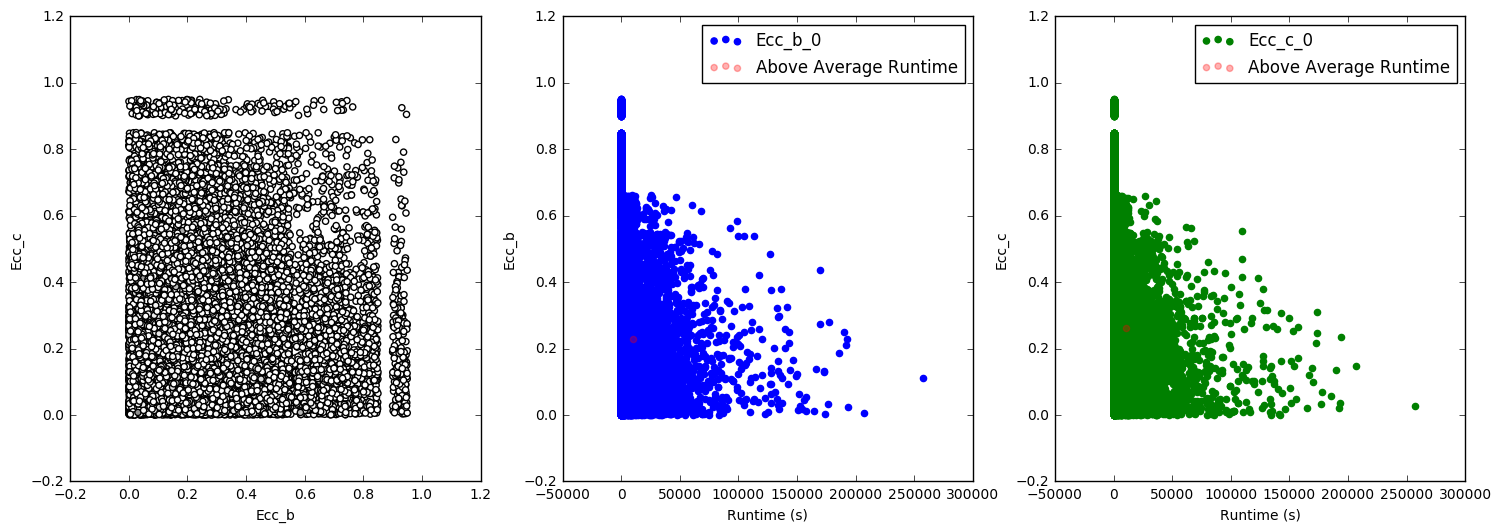

In [6]:
#need to grab the initial eccentricities for completed runs and compare with run time
fig,ax = plt.subplots(1,3)
fig.set_size_inches(18,6)

#plots ecc_b_0, ecc_c_0, and runtime

ax[0].scatter(c['Ecc_b_0'],c['Ecc_c_0'], c=c['Runtime'], cmap='Greys', linewidth=1)
ax[1].scatter(c['Runtime'],c['Ecc_b_0'],color='blue')
ax[2].scatter(c['Runtime'],c['Ecc_c_0'],color='green')

#identifies the runs that took longer than the average runtimes:

applied_mask = avg_runtime #from masks made in cell above
ax[1].scatter(c['Runtime'][applied_mask],c['Ecc_b_0'][applied_mask],color='red',alpha=0.3,label='Above Average Runtime')
ax[2].scatter(c['Runtime'][applied_mask],c['Ecc_c_0'][applied_mask],color='red',alpha=0.3,label='Above Average Runtime')

ax[0].set_ylabel('Ecc_c')
ax[0].set_xlabel('Ecc_b')

ax[1].set_ylabel('Ecc_b')
ax[1].set_xlabel('Runtime (s)')

ax[2].set_ylabel('Ecc_c')
ax[2].set_xlabel('Runtime (s)')

ax[1].legend(loc=0)
ax[2].legend(loc=0)

    

    

In [4]:
#avg_runtime
gt_avg_rt_mask = np.where(c['Runtime']>=avg_runtime) #86400s = 1 day; or use the average runtime;
lt_avg_rt_mask = np.where(c['Runtime']<avg_runtime)

avg_ecc_gt_b = c['Ecc_b_0'][gt_avg_rt_mask].mean()
avg_ecc_lt_b = c['Ecc_b_0'][lt_avg_rt_mask].mean()
print('Average Ecc_b_0 for sims w/ Runtime>avg_runtime',avg_ecc_gt_b,
      '\nAverage Ecc_b_0 for sims w/ Runtime<avg_runtime',avg_ecc_lt_b)

Average Ecc_b_0 for sims w/ Runtime>avg_runtime 0.19953674498 
Average Ecc_b_0 for sims w/ Runtime<avg_runtime 0.275166176878


In [16]:
# send rory case with large period, inputs
# see if longer runs have e > 0.22
# histogram of run times with freq (bins of runtime)
# ecc vs runtime
#np.argmax(data_per)


22114

In [ ]:
#continue hyak
#scatter plot of runtimes and ecc_b, ecc_c, initial. 


In [ ]:
#pull comp/uncomp ecc_c for 25000 hyak runs. 
#plot ecc_b, ecc_c, with color coded runtime. 
#highest runtime --> ecc of b and c? are they large?
#rad/per contour plot

In [ ]:
#determine which runs have been completed with eq_only and eq+distorb; see if any have merged with distorb.

In [ ]:
#change inc_c to 0 to 20; inc_b = 0; bInvPlane = 1 in b.in; 
#questions:
#R_crit = 2earthRad, if R = 2.1 earthRad, does it make sense for Qp = 10^6
#how many times can i take the physics GRE, and how will grad schools look at the scores?
#register for credits

In [ ]:
# final ecc of b vs when there is another
        # take final outputs make .in and run for 1000 years 1 year resolution,
# graph ecc_eq vs ecc_eq+distor
# same with semi; encodes how many merged
# how many merged; 
